<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Aprendizaje%20Supervisado/Derivative_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Derivatives Pricing***
El objetivo de este proyecto es realizar la fijación de precios de los derivados desde un punto de vista del aprendizaje automático y utilizar un modelo basado en regresión supervisada para aprender el modelo de precios de opciones de Black-Scholes a partir de datos simulados.


## **Content**

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Defining function and parameters](#1.2)
    * [2.3. Load Dataset](#1.3)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and evaluation metrics](#4.1)
    * [5.2. Compare Models and Algorithms](#4.2)
* [6. Model Tuning and finalizing the model](#5)
* [7. Additional analysis: removing the volatilty data](#6)

<a id='0'></a>
# 1. Problem Definition

En el marco de regresión supervisada utilizado para este proyecto, el problema de fijación de precios de los derivados se define en el marco de regresión, donde la variable predicha es el precio de la opción, y las variables predictoras son los datos de mercado que se utilizan como entradas para el modelo de fijación de precios de opciones *Black-Scholes*.

Las opciones se han utilizado en las finanzas como medio para cubrir el riesgo de forma no lineal. También son utilizadas por los especuladores para hacer apuestas apalancadas en los mercados financieros. Históricamente, se ha utilizado la fórmula de *Black Scholes*.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

Con:

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

Y:

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

**Donde tenemos;**
    *Precio de la acción* $S$;
    *Precio de ejercicio* $K$;
    *Tasa libre de riesgo* $r$;
    *Rendimiento anual de dividendos* $q$;
    *Tiempo hasta el vencimiento* $\tau = T-t$ (*representado como una fracción menos de un año*);
    *Volatilidad* $\sigma$

Para simplificar la lógica, definimos *Moneyness* como $𝑀=𝐾/𝑆$ y miramos los precios en términos de por unidad de precio de la acción actual. También establecemos $𝑞$ como $0$

Esto simplifica la fórmula a lo siguiente:

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### **Vol Suface**
En el mercado de opciones, no hay un único valor de volatilidad que nos dé el precio correcto. A menudo encontramos la volatilidad tal que la salida coincide con el precio.

### **Simulación**
En este ejercicio, asumimos la estructura de la superficie del vol. En la práctica, obtendríamos los datos de un proveedor de datos.

Utilizamos la siguiente función para generar la superficie de volatilidad de la opción.

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2.2. Defining functions and parameters
**True Parameters**

In [ ]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [ ]:
risk_free_rate = 0.05

* Como primer paso definimos los parametros constantes.
* Se espera que estos parametros no tengan un impacto significativo en el precio de la opcion.

**Vol and Option Pricing Functions**

In [ ]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

## 2.3. Data Generation

In [ ]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

* El tiempo hasta el vencimiento (Ts) se genera utilizando la funcion np.random.random, que genera una variable aleatoria uniforme entre cero y uno.
* El dinero (Ks) se genera utilizando la funcion np,random.randn, que genera una variable aleatoria normalmente distribuida. EL numero aleatorio multiplicado por 0.25 genera la desviacion del precio de ejercicio con respecto al precio al contado ( cuando el precio al contado es igual al preco de ejecicio, opcion *at-the-money*) y la ecuacion global garantiza que el dinero es mayor que cero.
* Volatilidad (*sigma*) se genera en funcion del tiempo hasta el vencimiento y el dinero utilizando la ecuacion $ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$.
* El precio de la opcion se genera utilizando la ecuacion $  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $, para el precio de la opcion Black-Scholes.
* En Total generamos 10,000 puntos de datos (N). 

**Set the Endog and Exog Data**

In [ ]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

* Ahora creamos las variables de prediccion y predictoras.

# 3. Exploratory Data Analysis

## 3.1. Descriptive Statistics

In [ ]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.239580,0.937867,0.808447,0.281231
1,0.087285,1.074000,0.354183,0.235966
2,0.003008,1.212797,0.139477,0.218476
3,0.219839,0.784248,0.103453,0.215000
4,0.000005,1.295926,0.079979,0.216755


* El conjunto de datos contiene el precio "*que es el precio de la opcion y es la variable predicha*", junto con el dinero "*la relacon entre el precio de ejercicio y el precio al contado*", el tiempo de vencimiento y la volatilidad, que son las caracteristicas del modelo.

In [ ]:
pd.set_option('precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.175,1.005,4.969e-01,0.256
std,0.134,0.247,2.888e-01,0.030
min,0.000,0.048,1.088e-04,0.200
25%,0.071,0.838,2.462e-01,0.231
50%,0.157,1.007,4.970e-01,0.256
75%,0.249,1.172,7.446e-01,0.280
max,0.952,1.938,9.999e-01,0.362


## 3.2. Data Visualization

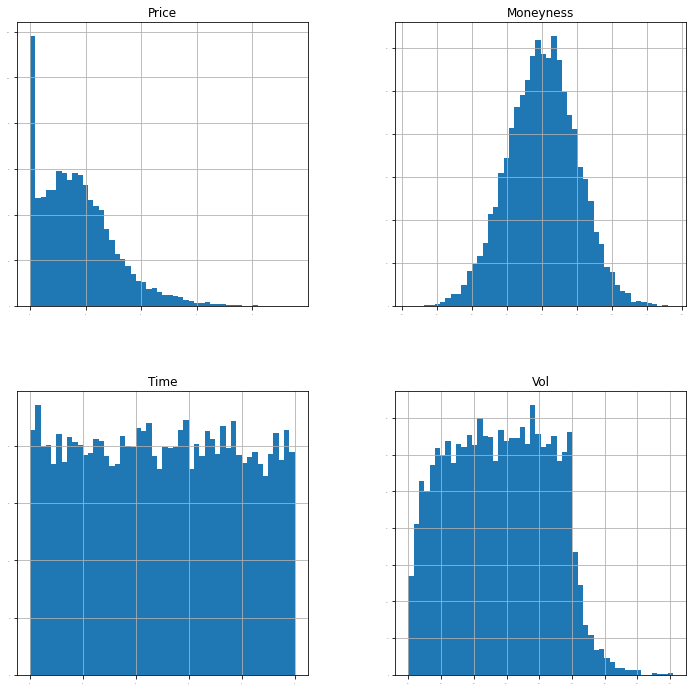

In [ ]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

* Podemos ver que el precio tiene una distribución interesante con un pico en $0$

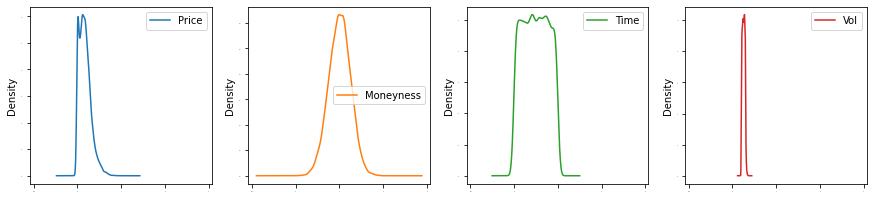

In [ ]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

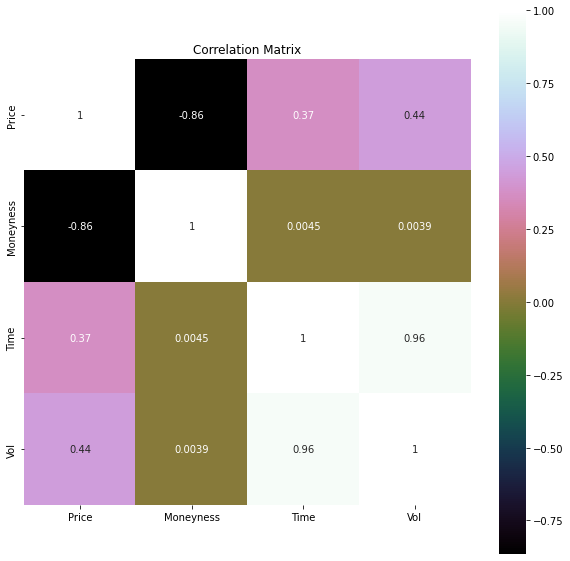

In [ ]:
correlation = dataset.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

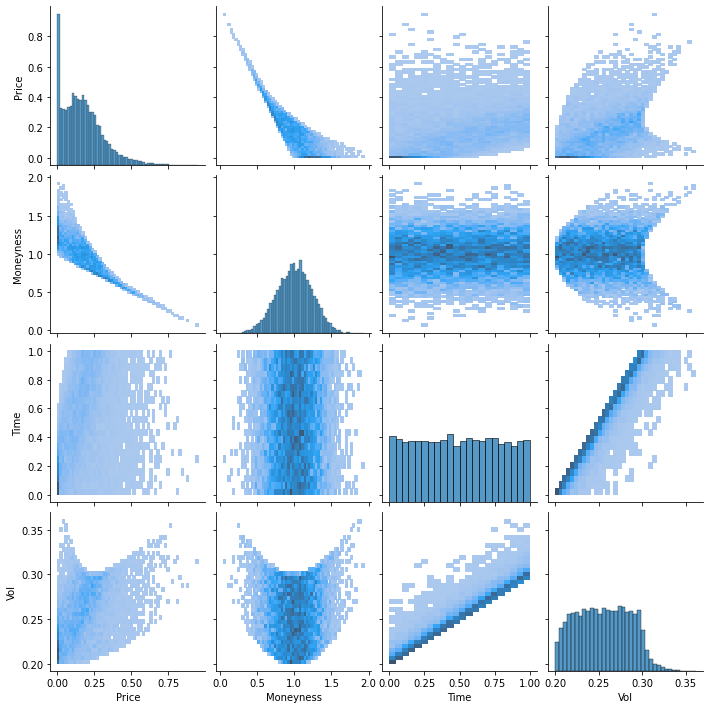

In [ ]:
sns.pairplot(dataset, kind="hist")

* Observando que, amedida que disminuye el dinero (es decir el precio de ejercicio disminuye en comparacion con el precio de las acciones), se produce un aumento en el precio.
*  Si observamos el precio frente al tiempo hasta el vencimiento, vemos un aumento del precio de la opcion.
E l grafico del precio frente a la volatilidad tambien muestra un aumento del precio con la volatilidad.
* Sin embargo, el precio de la opcion parece mostrar una relacion no lineal con las mayorias de las variables.
* Otra relacion interesante es la existente entre la volatilidad y el strike. Cuanto mas mos desviemos del Moneyness de uno, mayor sera la volatilidad que observamos. 
* Vemos algunos análisis no lineales muy interesantes. Esto significa que esperamos que nuestros modelos no lineales hagan un mejor trabajo que nuestros modelos lineales.

# 4. Data Preparation and Analysis

## 4.1. Univariate Feature Selection

In [ ]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])

# concatenar dos marcos de datos para una mejor visualización 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # nombrar las columnas del marco de datos
featureScores.nlargest(10,'Score').set_index('Specs')  # imprimir 10 mejores características

,Score
Specs,
Moneyness,29605.602
Vol,2407.205
Time,1558.442


* Observamos que el dinero (*Moneyness*) es la variable más importante para el precio.

# 5. Evaluate Algorithms and Models

## 5.1. Train Test Split and Evaluation Metrics

In [ ]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

Utilizamos los modelos scikit preconstruidos para realizar un análisis de pliegues K en nuestros datos de entrenamiento. A continuación, entrenamos el modelo en los datos de entrenamiento completos y lo utilizamos para la predicción de los datos de prueba. Los parámetros para el análisis de pliegues K se definen como:

In [ ]:
num_folds = 10
seed = 7

scoring = 'neg_mean_squared_error' 

## 5.2. Compare Models and Algorithms


In [ ]:
models = []

# Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural Network Predictor
models.append(('MLP', MLPRegressor()))

# Boosting and Bagging Methods
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000349 (0.000026) 0.000348 0.000379
LASSO: 0.018031 (0.001384) 0.018029 0.017649
EN: 0.018031 (0.001384) 0.018029 0.017649
KNN: 0.000017 (0.000016) 0.000009 0.000012
CART: 0.000011 (0.000003) 0.000000 0.000009
SVR: 0.005444 (0.000151) 0.005424 0.005464
MLP: 0.000034 (0.000021) 0.000019 0.000021
ABR: 0.000720 (0.000045) 0.000736 0.000748
GBR: 0.000022 (0.000003) 0.000016 0.000020
RFR: 0.000004 (0.000005) 0.000001 0.000002
ETR: 0.000002 (0.000004) 0.000000 0.000000


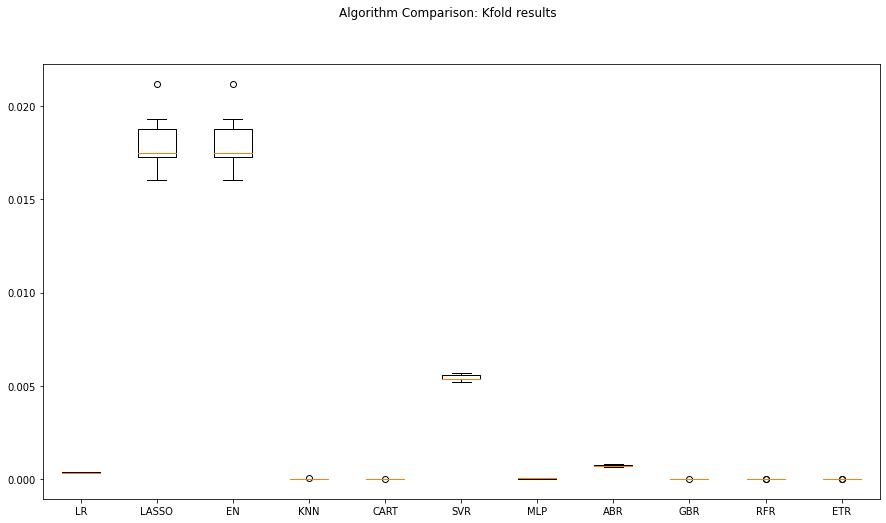

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

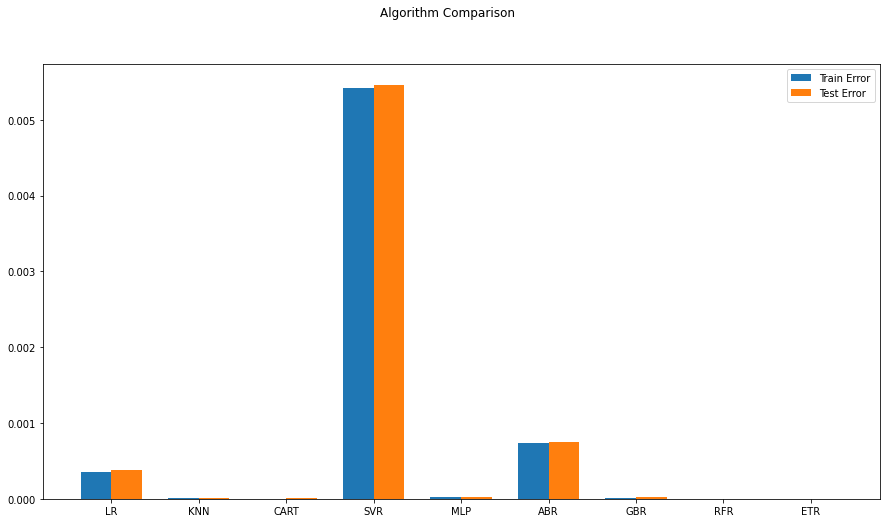

In [ ]:
# comparar algoritmos
fig = plt.figure()

ind = np.arange(len(names)-2)  # las ubicaciones x para los grupos
width = 0.35  # la anchura de las barras

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
plt.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
plt.show()

* Vemos que el algoritmo del perceptrón multicapa (MLP) lo hace mucho mejor que el algoritmo lineal. Sin embargo, los métodos CART y Forest también hacen un buen trabajo. Dado que MLP es uno de los mejores modelos, realizamos la búsqueda de la red para el modelo MLP en el siguiente paso.

# 6. Model Tuning and finalising the model
Como se muestra en el gráfico anterior, el modelo MLP es uno de los mejores, por lo que realizamos el ajuste del modelo. Realizamos una búsqueda en cuadrícula con diferentes combinaciones de capas ocultas en el modelo MLP.

In [ ]:
'''
hidden_layer_sizes : tupla, longitud = n_capas - 2, por defecto (100,)
    El ith elemento representa el número de neuronas en el ith
    capa oculta.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000034 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000598 (0.000557) with: {'hidden_layer_sizes': (20,)}
-0.000114 (0.000091) with: {'hidden_layer_sizes': (50,)}
-0.000105 (0.000079) with: {'hidden_layer_sizes': (20, 20)}
-0.000034 (0.000022) with: {'hidden_layer_sizes': (20, 30, 20)}


* El mejor modelo tiene 3 capas con  20, 30, 10 nodos en cada capa oculta.

In [ ]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [ ]:
# estimar la precisión en el conjunto de validación
# transformar el conjunto de datos de validación
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

2.3475039476084102e-05


* Vemos que el error medio (RMSE) es de 2.34e-5 , que es menos de un céntimo. Por lo tanto, el modelo de aprendizaje profundo hace un excelente trabajo de ajuste del modelo de valoración de opciones Black-Scholes. La precisión puede mejorarse con más ajustes.

# 7. Additonal analysis: removing the volatilty data.
A continuación, complicamos el proceso intentando predecir el precio sin los datos de volatilidad.

In [ ]:
X = X[:, :2]

In [ ]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [ ]:
num_folds = 10
seed = 7

scoring = 'neg_mean_squared_error' 

In [ ]:
models = []

# Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural Network Predictor
models.append(('MLP', MLPRegressor()))

# Boosting and Bagging Methods
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002005 (0.000284) 0.002001 0.002293
KNN: 0.000017 (0.000016) 0.000009 0.000012
CART: 0.000010 (0.000002) 0.000000 0.000009
SVR: 0.005937 (0.000098) 0.005875 0.005929
MLP: 0.000060 (0.000027) 0.000016 0.000018
ABR: 0.000720 (0.000037) 0.000669 0.000692
GBR: 0.000022 (0.000002) 0.000017 0.000021
RFR: 0.000004 (0.000005) 0.000001 0.000002
ETR: 0.000001 (0.000003) 0.000000 0.000001


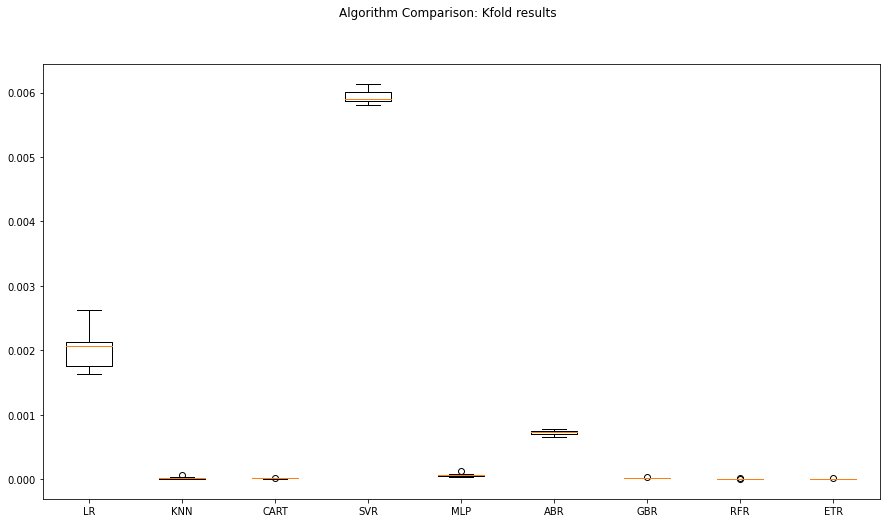

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

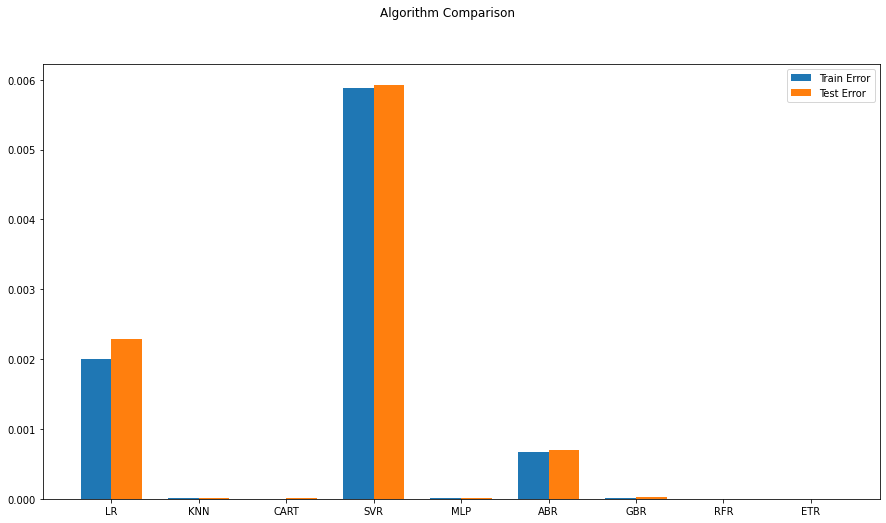

In [ ]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

* Podemos ver que la regresión lineal ahora hace un trabajo peor que antes, esto es esperado ya que hemos añadido una mayor cantidad de no linealidad.

# Conclusions
* El modelo de regresión lineal no obtuvo tan buenos resultados como nuestros modelos no lineales y los modelos no lineales tienen un rendimiento muy bueno en general.

* La red neuronal artificial (RNA) puede reproducir la fórmula de fijación de precios de opciones de Black y Scholes para una opción de compra con un alto grado de precisión, lo que significa que podemos aprovechar el eficiente cálculo numérico del aprendizaje automático en la fijación de precios de los derivados sin depender de las suposiciones poco prácticas de los modelos tradicionales de fijación de precios de los derivados.